<a href="https://colab.research.google.com/github/Spring1077/TC2008B/blob/main/Game_of_Life_(Covid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera actividad en clase, donde aprendimos utilizar el Game of Live, simulando el covid.

# Reglas

1. Si hay menos de dos vecinos contagiados, se esta saludable.
2. Si hay más de un vecino contagiado, se contagia.
3. Cuando un agente esta contagiado y tiene más de dos vecinos contagiados se muere.
4. Si un agente esta contagiado y no tiene vecinos contagiados, vuelve a estar saludable
 

In [1]:
!python3 -m pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 3.7 MB/s eta 0:00:00


In [2]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model 

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [3]:
old_cmap = mlp.cm.get_cmap('viridis', 3) # cambiar el digito de la lista para poder usar mas colores
colors = old_cmap(np.linspace(0, 1, 3)) # cada vez que se agragan colores cambiar el ultimo digito de la lista

colors[0] = np.array([256/256, 0/256, 0/256, 1]) # Red
colors[2] = np.array([0/256, 256/256, 0/256, 1]) # Green

colors[1] = np.array([150/256, 150/256, 150/256, 1]) # Grey

# colors[3] = np.array([145/256, 94/256, 55/256, 1]) # Brown
# colors[4] = np.array([130/256, 130/256, 50/256, 1]) # Olive
# colors[5] = np.array([10/256, 100/256, 20/256, 1]) # Dark Green
#
# colors[6] = np.array([250/256, 250/256, 250/256, 1]) # White
# colors[7] = np.array([86/256, 102/256, 255/256, 1]) # Blue
# colors[8] = np.array([185/256, 89/256, 255/256, 1]) # Purple
# colors[9] = np.array([10/256, 10/256, 10/256, 1]) # Black
colormap = mlp.colors.ListedColormap(colors)

In [4]:
class GameLifeAgent(Agent):
    """
    Representa a un agente o una celda con estado saludable (2), contagiado (1) o muerto (0)
    """
    def __init__(self, unique_id, model):
        """
        Crea un agente con estado inicial aleatorio de 0 ó 2, también se le asigna un identificador
        formado por una tupla (x,y). Se define un nuevo estado cuyo valor será definido por las
        reglas mencionadas arriba.
        """
        # Dar los estados a cada celda, dependiendo de la condiciones de salud
        super().__init__(unique_id, model) 
        # Se necesitan poner los valores que son necesarios, segun el caso que se evalua
        self.live = np.random.choice([0,1,2]) # Asigna un estado aleatoria a cada agente
        self.contagious = self.live == 1 # Para que un agente este contagiado tiene que tener el estado con valor 1
        # self.dead = self.live == 0 # Si un agente esta muerto si tiene que quedar muerto
        self.next_state = None
    
    def step(self):
        """
        Este método es el que calcula si la celda estará saludable, contagiada o muerta dependiendo el estado de sus vecinos.
        Esta es la dinámica principal del juego de la vida. Por lo tanto, el estado live de la
        siguiente generación no se cambia aquí, solo se almacena en self.next_state. La idea consiste
        en esperar a que todos los agentes calculen su estado y una vez hecho esto, hacer el cambio.
        """

        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)

        # Contar vecinos totales alrededor
        # live_neighbours = np.sum([neighbour.live for neighbour in neighbours])
        live_neighbours = 0
        for neighbor in neighbours:
            live_neighbours = live_neighbours + neighbor.live

        # Saber cuantos contagiados hay alrededor 
        # contagious_neighbors = np.sum([neighbour.contagious for neighbour in neighbours])
        contagious_neighbors = 0
        for neighbor in neighbours:
          contagious_neighbors = contagious_neighbors + neighbor.contagious

        # Si hay dos vecinos contagiados nos contagiamos
        self.next_state = self.live
        if self.next_state == 2 and (contagious_neighbors > 1):
            self.next_state = 1

        # Si un agente esta contagiado, pero no tiene vecinos contagiados vuelve a estar saludable
        elif live_neighbours >= 1 and (contagious_neighbors == 0):
          self.next_state = 2
        
        # Si estas contagiado y tienes mas de dos vecinos contagiados, mueres
        else:
          if live_neighbours >= 1 and (contagious_neighbors > 1):
            self.next_state = 0

    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.live = self.next_state
        self.contagious = self.live == 1

class GameLifeModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        for (content, x, y) in self.grid.coord_iter():
            a = GameLifeAgent((x, y), self)
            self.grid.place_agent(a, (x, y))
            self.schedule.add(a)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "Live": self.get_live,
                             "Contagious": self.get_contagious}
        )
    
    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            grid[x][y] = cell_content.live

        return grid

    def get_live(self):
        total_live_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent):
                total_live_agents += agent.live

        return total_live_agents

    def get_contagious(self):
        total_contagious_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent):
                total_contagious_agents += agent.contagious

        return total_contagious_agents

In [5]:
# Definimos el tamaño del Grid
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 50

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = GameLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:19.416108


In [6]:
all_grids = model.datacollector.get_model_vars_dataframe()

In [7]:
all_grids

,Grid,Live,Contagious
0,"[[2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0,...",10022,3374
1,"[[2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",4997,3207
2,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",2088,1186
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",2240,874
4,"[[0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0,...",3570,726
5,"[[0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0,...",5408,690
6,"[[2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0,...",7189,683
7,"[[2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0,...",8633,679
8,"[[2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0,...",9662,684
9,"[[2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0,...",10302,682


In [8]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

patch_grid = axs.imshow(model.get_grid(), cmap=colormap)

cells_alive = []
cells_contagious = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])

    cells_alive.append(all_grids['Live'].iloc[i])

    cells_contagious.append(all_grids['Contagious'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [9]:
anim

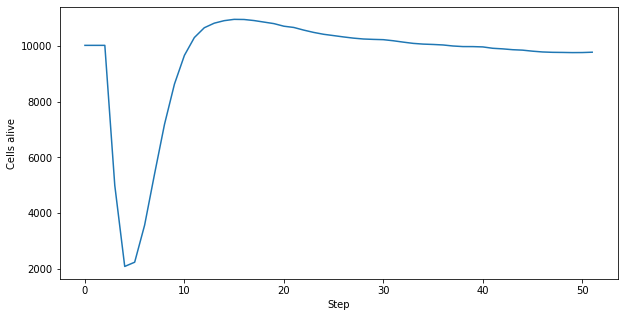

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells alive")

plt.plot(cells_alive)
plt.show()

# Gráfica 1

Aquí podemos ver como se comportan los agentes con la condición saludable durante las generaciones puestas en la simulación

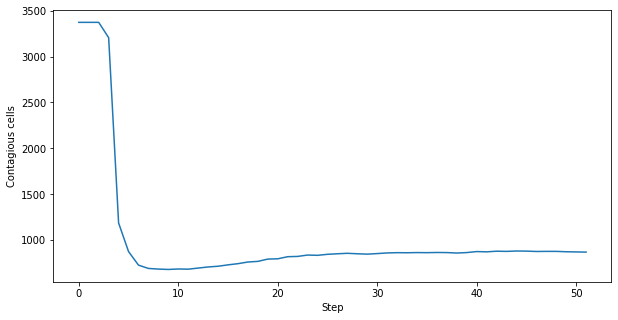

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Contagious cells")

plt.plot(cells_contagious)
plt.show()

# Gráfica 2

En está segunda gráfica podemos ver como se compartan los agentes con estado contagiado durante las generaciones puestas durante la simulación

In [12]:
import random
random.sample([1, 2, 3, 5], k=2)

[1, 5]

In [13]:
NUM_REPS = 100
GRID_SIZE = 10
NUM_GENERATIONS = 1000

model = GameLifeModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(time=[], alive=[], contagious=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_GENERATIONS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['time'].append(final_time - start_time)
    batch_data['alive'].append(all_grids['Live'].to_numpy())
    batch_data['contagious'].append(all_grids['Contagious'].to_numpy())

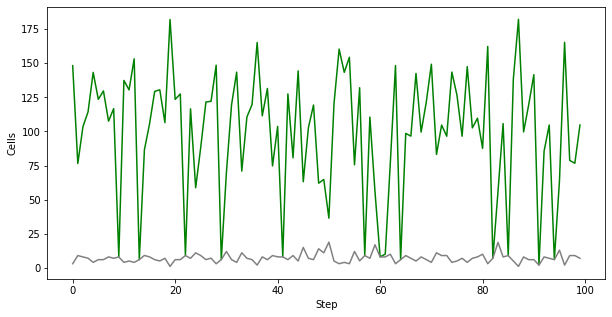

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells")

# axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
#plt.plot(batch_data['alive'], color='Green')
#plt.plot(batch_data['contagious'], color='Gray')

plt.plot(np.average(np.array(batch_data['alive']), axis=1), color='Green')
plt.plot(np.average(np.array(batch_data['contagious']), axis=1), color='Gray')

plt.show()

# Gráfica 3

Comparativa entre agentes con estado saludable y contagiados durante las generaciones puestas en la simulación